# **Proyecto para HACKATON BARCELONA DIGITAL TALENT**

# **APARTADO DE MODELIZACIÓN**

## **Realizado por:** Esteban Braganza

En este cuaderno se desarrolla la parte de modelización en las bases de datos propuestas para el concurso.

In [ ]:

## Importamos librerías

import sys

!{sys.executable} -m pip install -U pandas-profiling[notebook]
!jupyter nbextension enable --py widgetsnbextension

import numpy as np
import pandas as pd
import pickle
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

from pandas_profiling import ProfileReport
#from pandas_profiling.utils.cache import cache_file

import plotly as py
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

# Librerias de modelado
from sklearn import model_selection as ms
from sklearn import preprocessing,linear_model## 
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import QuantileTransformer
from sklearn import metrics
from sklearn import linear_model
import lightgbm as lgb
import xgboost as xgb
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.tree import export_graphviz
import graphviz


Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [ ]:
### Algunas Funciones utiles

def plot_categories(df, column, target,target_categoric=True):
    
    """Dibuja el numero de casos que tiene una categoria y tambien un boxplot con el target en caso de que el
    target es numerico. Si el target es categorico dibuja un grafico en el que vemos 
    cuanto discriminan las categorias"""
    if target_categoric== False:

      # Plot1
        
        plt.figure(figsize=(30,10))
        plt.subplot(2,1,1)
        splot=sns.countplot(df[column])

        for p in splot.patches:
          splot.annotate(format(p.get_height(), '.0f'), 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha = 'center', va = 'center', 
                        size=15,
                        xytext = (0, -12), 
                        textcoords = 'offset points')
        
        #Plot 2
        
        plt.subplot(2,1,2)
        splot2=sns.boxenplot(
        data = df, 
        x = column,
        y = target)
        for p in splot2.patches:
          splot2.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=15,
                   xytext = (0, -12), 
                   textcoords = 'offset points')
        plt.xticks(rotation=45)

        # Show
        plt.show()


    else:
      
        plt.figure(figsize=(30,10))

        # Plot 1
        
        plt.subplot(2,1,1)
        splot=sns.countplot(df[column])
        for p in splot.patches:
          splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=15,
                   xytext = (0, -12), 
                   textcoords = 'offset points')
          
        plt.xticks(rotation=45)

        # Plot 2

        plt.subplot(2,1,2)
        splot2=sns.countplot(x=column,hue=target, 
                    data=df)
        for p in splot2.patches:
          splot2.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=15,
                   xytext = (0, -12), 
                   textcoords = 'offset points')

        # Show      
        plt.show()
        

def generate_simple_report(data_frame):
  
  print('-- Un vistazo Rapido --')
  print(data_frame.head(10))
  print()
  print('-- Informacion de las Variables --')
  print(data_frame.info())
  print()
  print('-- Descripcion de las Variables --')
  print(data_frame.describe())
  print()
  print('--Nulos dentro del Data Set --')
  print(pd.DataFrame(data_frame.isnull().sum(), columns =['NULOS']).reset_index().sort_values(by ='NULOS', ascending = True))
  print()
  print('--Valores Duplicados--')
  print('Duplicados: ',data_frame.duplicated().sum())
  print()
  print('--Valores Unicos--')
  print(pd.DataFrame(data_frame.nunique(),columns=['unique_values']).reset_index().sort_values('unique_values',ascending=False))



In [ ]:
clients = pd.read_csv('/content/drive/MyDrive/Hackaton Barcelona/mwc22-client_table.csv')
orders = pd.read_csv('/content/drive/MyDrive/Hackaton Barcelona/mwc22-orders_table.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Hackaton Barcelona/mwc22-client_table+-+test_x.csv')

In [ ]:
generate_simple_report(clients)

-- Un vistazo Rapido --
   CLIENT ID  CLIENT_SEGMENT AVG CONSO AVG BASKET SIZE  RECEIVED_COMMUNICATION
0   24321771               6     67,25          201,75                       0
1   24321859               2     58,33             350                       0
2   24321880               3     46,67             112                       0
3   24321957               2        50             600                       0
4   24321962               4        10             120                       0
5   24322000               5      9,17             110                       0
6   24322006               3     58,33             100                       0
7   24322026               4     29,17            87,5                       0
8   24322170               1    116,67             200                       0
9   24322371               2     83,33             200                       0

-- Informacion de las Variables --
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35884 entries, 0 to 3

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:2593: UserWarning: n_quantiles (1000) is greater than the total number of samples (19). n_quantiles is set to n_samples.
  "n_samples." % (self.n_quantiles, n_samples)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:2593: UserWarning: n_quantiles (1000) is greater than the total number of samples (19). n_quantiles is set to n_samples.
  "n_samples." % (self.n_quantiles, n_samples)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adap

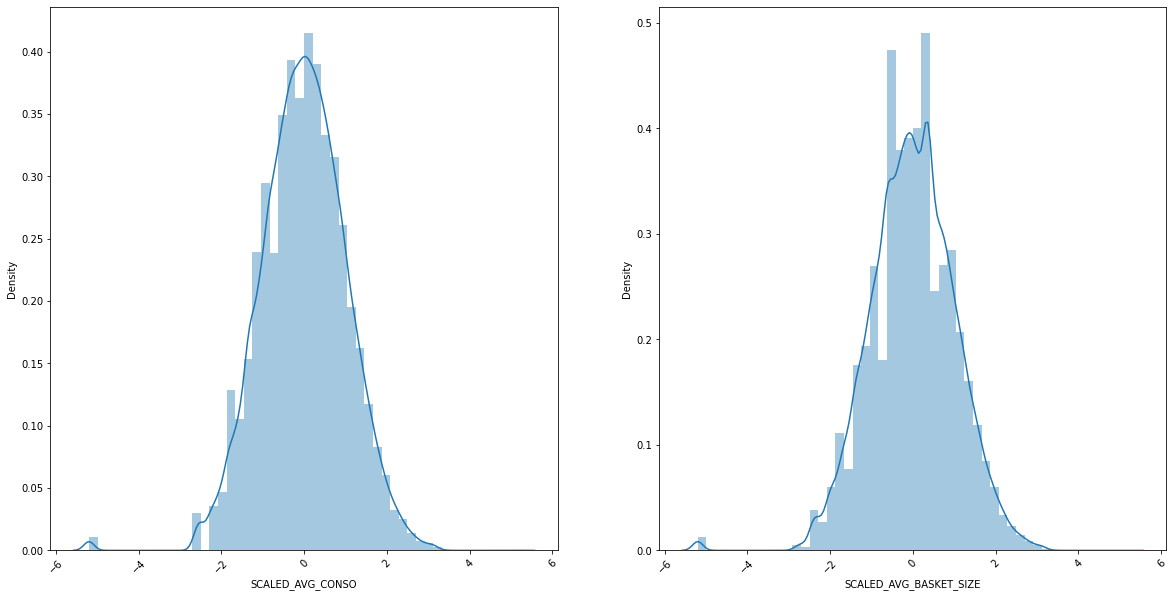

In [ ]:
# Preprocessing de los datos 

def preprocessing_clients_data(data, test = False):
  # Turn to numerical values
  data['AVG BASKET SIZE'] = data['AVG BASKET SIZE'].str.replace(',','.')
  data['AVG CONSO'] = data['AVG CONSO'].str.replace(',','.')
  data['AVG BASKET SIZE'] = data['AVG BASKET SIZE'].apply(lambda x: float(x))
  data['AVG CONSO'] = data['AVG CONSO'].apply(lambda x: float(x))

  #SCALE VALUES
  qt = QuantileTransformer(output_distribution='normal')
  data['SCALED_AVG_CONSO'] = qt.fit_transform(data[['AVG CONSO']].values.reshape(-1,1))
  data['SCALED_AVG_BASKET_SIZE'] = qt.fit_transform(data[['AVG BASKET SIZE']].values.reshape(-1,1))

  # SET INDEX
  data.set_index('CLIENT ID', inplace=True)

  # CHANGE VAR NAMES

  if test == False:
    data= data[['CLIENT_SEGMENT', 'SCALED_AVG_CONSO', 'SCALED_AVG_BASKET_SIZE', 'RECEIVED_COMMUNICATION']]
    data.columns = ['TARGET', 'SCALED_AVG_CONSO', 'SCALED_AVG_BASKET_SIZE', 'RECEIVED_COMMUNICATION']

  elif test == True:
    data= data[['SCALED_AVG_CONSO', 'SCALED_AVG_BASKET_SIZE', 'RECEIVED_COMMUNICATION']]

  return data

# Preprocess

clients = preprocessing_clients_data(data=clients)
test_df = preprocessing_clients_data(data=test_df, test = True)

# Revisamos las variables transformadas

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
sns.distplot(clients['SCALED_AVG_CONSO'],bins=50)
plt.xticks(rotation=45)

plt.subplot(1,2,2)
sns.distplot(clients['SCALED_AVG_BASKET_SIZE'],bins=50)
plt.xticks(rotation=45)

plt.show()




In [ ]:
# Obtenemos los indices de lo que seran las bases de entrenamiento y validacion manteniendo la distribucion de las clases.

def stratified_split(df, target, val_percent=0.2):
    '''
    Function to split a dataframe into train and validation sets, while preserving the ratio of the labels in the target variable
    Inputs:
    - df, the dataframe
    - target, the target variable
    - val_percent, the percentage of validation samples, default 0.2
    Outputs:
    - train_idxs, the indices of the training dataset
    - val_idxs, the indices of the validation dataset
    '''
    classes=list(df[target].unique())
    train_idxs, val_idxs = [], []
    for c in classes:
        idx=list(df[df[target]==c].index)
        np.random.shuffle(idx)
        val_size=int(len(idx)*val_percent)
        val_idxs+=idx[:val_size]
        train_idxs+=idx[val_size:]
    return train_idxs, val_idxs


train_idxs, val_idxs = stratified_split(clients, 'TARGET', val_percent=0.25)


Proportion of records with 6: 0.088 (3140 / 35884)
Proportion of records with 2: 0.19 (6760 / 35884)
Proportion of records with 3: 0.23 (8123 / 35884)
Proportion of records with 4: 0.22 (7927 / 35884)
Proportion of records with 5: 0.096 (3429 / 35884)
Proportion of records with 1: 0.18 (6505 / 35884)
Proportion of records with 6: 0.088 (3140 / 35884)
Proportion of records with 2: 0.19 (6760 / 35884)
Proportion of records with 3: 0.23 (8123 / 35884)
Proportion of records with 4: 0.22 (7927 / 35884)
Proportion of records with 5: 0.096 (3429 / 35884)
Proportion of records with 1: 0.18 (6505 / 35884)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



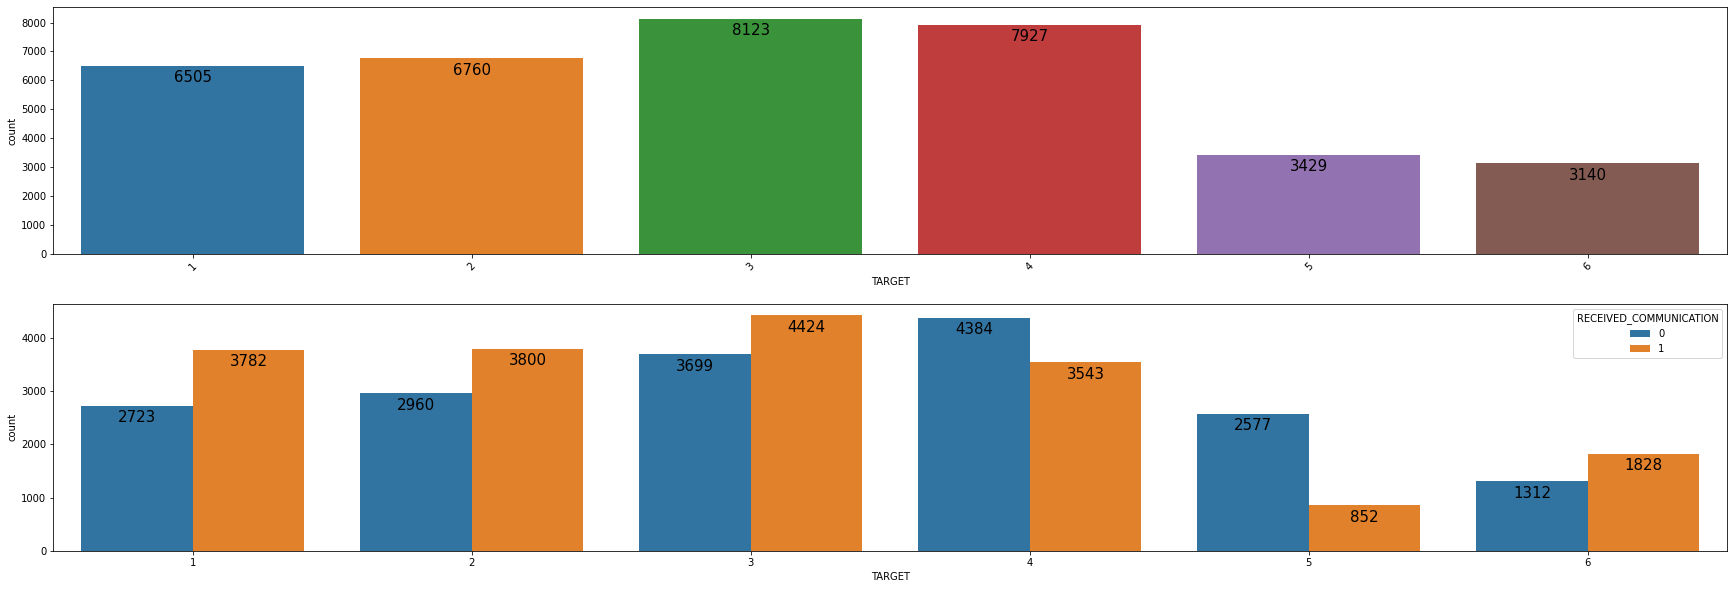

In [64]:
from re import A
def test_stratified(df, col):
    '''
    Analyzes the ratio of different classes in a categorical variable within a dataframe
    Inputs:
    - dataframe
    - categorical column to be analyzed
    Returns: None
    '''
    classes=list(df[col].unique())
    
    weights = {}
    for c in classes:
        print(f'Proportion of records with {c}: {len(df[df[col]==c])*1./len(df):0.2} ({len(df[df[col]==c])} / {len(df)})')
        weights[c] = len(df[df[col]==c])*1./len(df)
    
    return weights

weights = test_stratified(clients, "TARGET")
test_stratified(clients, "TARGET")
plot_categories(clients, column ='TARGET', target ='RECEIVED_COMMUNICATION', target_categoric=True )



In [ ]:
# Scatter Plot que pinta la separabilidad de los datos.

fig = px.scatter(clients, x= 'SCALED_AVG_CONSO', y= 'SCALED_AVG_BASKET_SIZE', color='TARGET', color_discrete_sequence=px.colors.qualitative.T10, title = 'Scatter plot datos estandarizados')
fig.show()

In [55]:
# Split Data 

def data_split(data, train_idxs, val_idxs, target):

  '''' Esta funcion separa las bases de entrenamiento y de prueba utilizando los indices proporcionados que obtuvimos antes'''

  train_df = data[data.index.isin(train_idxs)]
  test_df = data[data.index.isin(val_idxs)]
  
  # Train data
  X_train = train_df.loc[:, train_df.columns != target].values
  y_train = train_df[target].values

  # Test data
  X_test = test_df.loc[:, test_df.columns != target].values
  y_test = test_df[target].values

  return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = data_split(clients, train_idxs, val_idxs, 'TARGET')

  


In [56]:
## Reporte de estratificación en la estrategia de separación de datos de entrenamiento y valdiación

# La separacion de la base de datos mantiene la proporcion de datos.

print('---------- STRATIFIED SAMPLING REPORT ----------')
print('-------- Label proportions in FULL data --------')
test_stratified(clients, "TARGET")
print('-------- Label proportions in TRAIN data --------')
test_stratified(clients[clients.index.isin(train_idxs)], 'TARGET')
print('------ Label proportions in VALIDATION data -----')
test_stratified(clients[clients.index.isin(val_idxs)], 'TARGET')


---------- STRATIFIED SAMPLING REPORT ----------
-------- Label proportions in FULL data --------
Proportion of records with 6: 0.088 (3140 / 35884)
Proportion of records with 2: 0.19 (6760 / 35884)
Proportion of records with 3: 0.23 (8123 / 35884)
Proportion of records with 4: 0.22 (7927 / 35884)
Proportion of records with 5: 0.096 (3429 / 35884)
Proportion of records with 1: 0.18 (6505 / 35884)
-------- Label proportions in TRAIN data --------
Proportion of records with 6: 0.087 (2355 / 26915)
Proportion of records with 2: 0.19 (5070 / 26915)
Proportion of records with 3: 0.23 (6093 / 26915)
Proportion of records with 5: 0.096 (2572 / 26915)
Proportion of records with 4: 0.22 (5946 / 26915)
Proportion of records with 1: 0.18 (4879 / 26915)
------ Label proportions in VALIDATION data -----
Proportion of records with 4: 0.22 (1981 / 8969)
Proportion of records with 3: 0.23 (2030 / 8969)
Proportion of records with 6: 0.088 (785 / 8969)
Proportion of records with 2: 0.19 (1690 / 8969)
Pr

{1: 0.1812911138365481,
 2: 0.18842680343405063,
 3: 0.2263351544207827,
 4: 0.22087189207269484,
 5: 0.09555134351655703,
 6: 0.0875236927193667}

### **Svm Classifier**

In [114]:
# Probamos un modelo Support Vector Machines
from sklearn.multiclass import OneVsRestClassifier 
from sklearn.svm import LinearSVC, SVC
from sklearn.multiclass import OneVsOneClassifier


lsvc =SVC(random_state=0, kernel = 'rbf', decision_function_shape="ovo")
lsvc.fit(X_train, y_train)
predicted_labels = lsvc.predict(X_test)

print('Accuracy Score: ', accuracy_score(y_test,predicted_labels))
print('F1 Score: ', f1_score(y_test,predicted_labels, average = 'macro') )


Accuracy Score:  0.770319991080388
F1 Score:  0.6834956159504834


In [115]:
params = {
    'C'      : [0.1, 0.5,1, 10, 100, 1000],
    'gamma'         : [0.1, 1, 10, 100]

}


hpt = RandomizedSearchCV(estimator = lsvc,
                         param_distributions=params,
                         scoring='f1_macro',
                         n_iter=25,
                         verbose=1)
hpt.fit(X_train,y_train)

predicted_labels = hpt.best_estimator_.predict(X_test)

print('Accuracy Score: ', accuracy_score(y_test,predicted_labels))
print('F1 Score Micro: ', f1_score(y_test,predicted_labels, average = 'micro'))
print('F1 Score Macro: ', f1_score(y_test,predicted_labels, average = 'macro'))


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning:

The total space of parameters 24 is smaller than n_iter=25. Running 24 iterations. For exhaustive searches, use GridSearchCV.



Fitting 5 folds for each of 24 candidates, totalling 120 fits
Accuracy Score:  0.7782361467276173
F1 Score Micro:  0.7782361467276173
F1 Score Macro:  0.6910305839733102


### **Random Forest**

In [96]:

# Probamos un Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_jobs=2,random_state=27,
                       verbose=1,n_estimators = 600,max_depth=8)
#clf.fit(X_train,y_train)
#predicted_labels = clf.predict(X_test)


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    3.5s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    6.7s
[Parallel(n_jobs=2)]: Done 550 out of 550 | elapsed:    8.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done 550 out of 550 | elapsed:    1.0s finished


Accuracy Score:  0.7829189430259784
F1 Score:  0.6971241578260666
F1 Score:  0.7829189430259784


In [97]:
# Realizamos un tunning de hiperparametros del Random Forest

params = {
    'n_estimators'      : range(100,600,50),
    'max_depth'         : [8, 9, 10, 11, 12],
    'max_features': ['auto'],
    'criterion' :['gini']
}

gsearch1 = GridSearchCV(estimator = clf, param_grid = params, scoring='f1_macro',n_jobs=-1,verbose = 10, cv=5)
gsearch1.fit(X_train,y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    1.0s finished


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=8, n_estimators=550,
                                              n_jobs=2, random_state=27,
                                              verbose=1),
             n_jobs=-1,
             param_grid={'criterion': ['gini'], 'max_depth': [8, 9, 10, 11, 12],
                         'max_features': ['auto'],
                         'n_estimators': range(100, 600, 50)},
             scoring='f1_macro', verbose=10)

In [99]:
predicted_labels = gsearch1.best_estimator_.predict(X_test)

print('Accuracy Score: ', accuracy_score(y_test,predicted_labels))
print('F1 Score Macro: ', f1_score(y_test,predicted_labels, average = 'macro'))
print('F1 Score Micro: ', f1_score(y_test,predicted_labels, average = 'micro'))

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


Accuracy Score:  0.7828074478760174
F1 Score Macro:  0.6967015941594865
F1 Score Micro:  0.7828074478760174


[Text(0, 0, 'SCALED_AVG_CONSO'),
 Text(0, 0, 'SCALED_AVG_BASKET_SIZE'),
 Text(0, 0, 'RECEIVED_COMMUNICATION')]

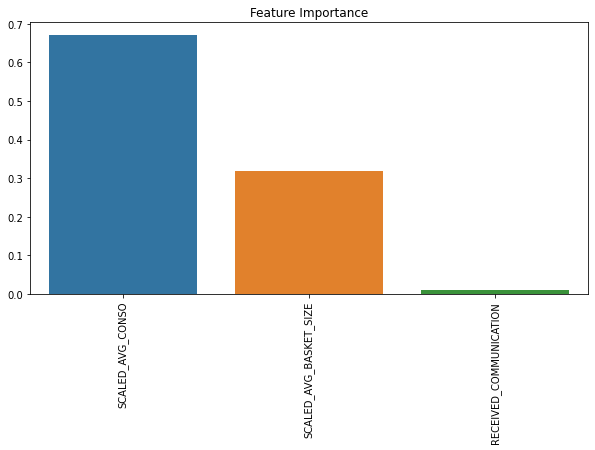

In [102]:
features = clients.loc[:, clients.columns != 'TARGET'].columns
plt.subplots(figsize=(10,5))
plot = sns.barplot(x=features, y=gsearch1.best_estimator_.feature_importances_)
plot.set_title('Feature Importance')
plot.set_xticklabels(plot.get_xticklabels(),rotation='vertical')

### **XGBoost**

In [108]:
# En este apartado pobamos un modelo XGBoost con funcion objetivo softmax para clasificar mas de dos clases.
  
## Modelo Base
xg = xgb.XGBClassifier(seed = 20, objective = 'multi:softmax')
xg.fit(X_train,y_train)
predicted_labels = xg.predict(X_test)

print('Accuracy Score: ', accuracy_score(y_test,predicted_labels))
print('F1 Score: ', f1_score(y_test,predicted_labels, average = 'macro') )

Accuracy Score:  0.7783476418775783
F1 Score:  0.6954926120153763


In [110]:
## Hyperparameter Tunning 

params = { 'max_depth': [3, 5, 6, 10, 15, 20],
           'learning_rate': [0.01, 0.1, 0.2, 0.3],
           'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bytree': np.arange(0.4, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
           'n_estimators': [100, 500, 1000]}

clf = RandomizedSearchCV(estimator = xg,
                         param_distributions=params,
                         scoring='f1_macro',
                         n_iter=25,
                         verbose=1)
clf.fit(X_train,y_train)

predicted_labels = clf.best_estimator_.predict(X_test)

print('Accuracy Score: ', accuracy_score(y_test,predicted_labels))
print('F1 Score Micro: ', f1_score(y_test,predicted_labels, average = 'micro'))
print('F1 Score Macro: ', f1_score(y_test,predicted_labels, average = 'macro'))


Fitting 5 folds for each of 25 candidates, totalling 125 fits
Accuracy Score:  0.7809120303266808
F1 Score Micro:  0.7809120303266808
F1 Score Macro:  0.6972516504439258


[Text(0, 0, 'SCALED_AVG_CONSO'),
 Text(0, 0, 'SCALED_AVG_BASKET_SIZE'),
 Text(0, 0, 'RECEIVED_COMMUNICATION')]

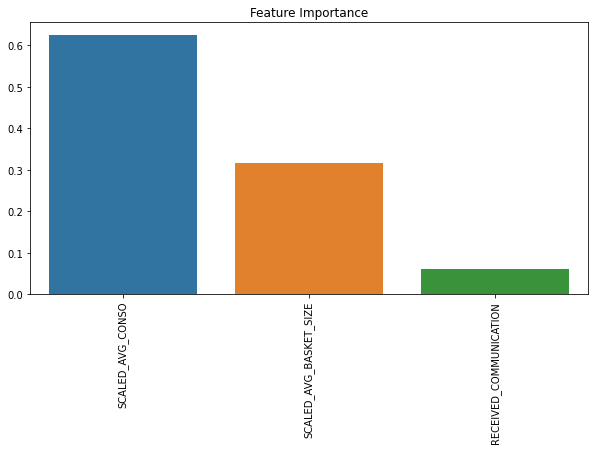

In [111]:
# Features Importances
features = clients.loc[:, clients.columns != 'TARGET'].columns
plt.subplots(figsize=(10,5))
plot = sns.barplot(x=features, y=clf.best_estimator_.feature_importances_)
plot.set_title('Feature Importance')
plot.set_xticklabels(plot.get_xticklabels(),rotation='vertical')

In [135]:
# Predicciones con Data Set test

best_model = clf.best_estimator_
final_predicted_labels = list(best_model.predict(test_df.values))
results_df = pd.DataFrame({'CLIENT ID':list(test_df.index),"CLIENT_SEGMENT":final_predicted_labels})
results_df.to_csv('/content/drive/MyDrive/Hackaton Barcelona/results.csv', sep =',',index = False)

results_df

,CLIENT ID,CLIENT_SEGMENT
0,48352078,5
1,18072186,2
2,48352246,3
3,18070621,4
4,48352262,4
5,48359553,4
6,18071647,5
7,48359574,3
8,48359627,3
9,18070505,1
